In [2]:
import matplotlib.pyplot as plt # A standard plotting library
import pandas as pd
import numpy as np
from glob import glob 
import seaborn as sns

In [ ]:
window_size = 256 # nucleotidi
cell_line="A549"
assembly="hg38"

## Epigenomic dataset

In [7]:
from epigenomic_dataset import load_epigenomes

promoters_epigenomes, promoters_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "promoters",
    window_size = window_size
)

enhancers_epigenomes, enhancers_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "enhancers",
    window_size = window_size
)

🟥 non capisco gli indici delle colonne

In [8]:
promoters_epigenomes[:3]

chrom                             PBX1  HOXB5  CTCF  NR5A2  POLR2AphosphoS2  \
chrom chromStart chromEnd strand                                              
chr1  628964     629220   +       0.69   0.22  0.20   0.67              0.0   
      629013     629269   +       0.59   0.11  0.14   0.60              0.0   
      629642     629898   +       0.00   0.07  0.43   0.10              0.0   

chrom                             FOSL2  CBX8  REST  ATAC-seq  JUN  ...  \
chrom chromStart chromEnd strand                                    ...   
chr1  628964     629220   +        0.49  0.29  0.55      0.77  0.0  ...   
      629013     629269   +        0.54  0.24  0.57      1.03  0.0  ...   
      629642     629898   +        0.00  0.01  0.11      5.57  0.0  ...   

chrom                             HOXB13  DNase-seq  CEBPB  RNF2  MYC  RFX5  \
chrom chromStart chromEnd strand                                              
chr1  628964     629220   +         0.43        0.0   0.27   0.0  0.0  0.18   
      629013     629269   +         0.38        0.0   0.19   0.0  0.0  0.18   
      629642     629898   +         0.03        0.0   0.00   0.2  0.0  0.49   

chrom                             CHD2  HOXA7  SIN3A  CHD4  
chrom chromStart chromEnd strand                            
chr1  628964     629220   +       0.24   0.68   0.20  0.02  
      629013     629269   +       0.24   0.52   0.24  0.07  
      629642     629898   +       0.00   0.08   0.06  0.00  

[3 rows x 48 columns]

In [10]:
epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

## Sequence data

🟥 Perchè mi servono altri dati? DEB regions?
- sequence mi ridà dove partono e finiscono le regioni nei cromosomi? il dataset sopra mi da che proteine(?) ci sono in quelle regioni?

In [12]:
from ucsc_genomes_downloader import Genome

genome = Genome(assembly)

Loading chromosomes for genome hg38:   0%|                                                      | 0/25 [00:00<…

In [13]:
genome

D:\Programmi\Anaconda\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Human, Homo sapiens, hg38, 2013-12-29, 25 chromosomes

In [14]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]
display(to_bed(epigenomes["promoters"])[:5])

chrom,chrom,chromStart,chromEnd,strand
0,chr1,628964,629220,+
1,chr1,629013,629269,+
2,chr1,629642,629898,+
3,chr1,629847,630103,+
4,chr1,629905,630161,+


🟥 sono la sequenza di un promoter? o la sequenza di cosa?

In [15]:
genome.bed_to_sequence(to_bed(epigenomes["promoters"])[:2])

array(['AAATGGTCATCCATCCTTTGGCCCCAATACCTAAACTAAGGTCTATGAACAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAAC',
       'CAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAACGCACTCTCCCCTGAACTCTACACAACATATTTTGTCACCAAGACCCTAC'],
      dtype='<U256')

In [16]:
# BedSequence preso un BED e un genoma ritorna i nucleotidi, li converte in un valore numerico, poi viene fatta 
# la codifica one-hot dei nucleotidi 
from keras_bed_sequence import BedSequence

def one_hot_encode(genome:Genome, data:pd.DataFrame, nucleotides:str="actg")->np.ndarray:
    return np.array(BedSequence(
        genome,
        bed=to_bed(data),
        nucleotides=nucleotides,
        batch_size=1
    ))

one_hot_encode(genome, epigenomes["promoters"][:2])

array([[[[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.]]]])

In [17]:
def flat_one_hot_encode(genome:Genome, data:pd.DataFrame, window_size:int, nucleotides:str="actg")->np.ndarray:
    return one_hot_encode(genome, data, nucleotides).reshape(-1, window_size*4).astype(int)

flat_one_hot_encode(genome, epigenomes["promoters"][:2], window_size)

array([[0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [18]:
def to_dataframe(x:np.ndarray, window_size:int, nucleotides:str="actg")->pd.DataFrame:
    return pd.DataFrame(
        x,
        columns = [
            f"{i}{nucleotide}"
            for i in range(window_size)
            for nucleotide in nucleotides
        ]
    )

In [19]:
sequences = {
    region: to_dataframe(
        flat_one_hot_encode(genome, data, window_size),
        window_size
    )
    for region, data in epigenomes.items()
}

In [20]:
sequences["promoters"][:2]
# avevamo una finestra di 200 nucleotidi, ognuno è codifiato one-hot da 4 elementi perché sono 4 le classi (actg)

,0a,0c,0t,0g,1a,1c,1t,1g,2a,2c,...,253t,253g,254a,254c,254t,254g,255a,255c,255t,255g
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0


# Data preprocessing


Se ho un dataset con più features che samples, c'è il rischio che l'algoritmo di apprendimento trovi una features che demarca in modo netto i samples senza che questa abbia un significato reale.

Quando aggiungo una features sto aggiungendo una dimensione allo spazio, se ho pochi punti, avrò punti sparpagliati su uno spazio molto grande


In [21]:
for region, x in epigenomes.items():
    print(
        f"The rate between features and samples for {region} data is: {x.shape[0]/x.shape[1]}"
    )
    print("="*80)

The rate between features and samples for promoters data is: 2080.8541666666665
The rate between features and samples for enhancers data is: 1318.4375


## NaN detection and imputation

In [54]:
# # HO CAMBIATO AXIS = 1 PERCHE NON TORNAVA
# for region, x in epigenomes.items():
#     print("\n".join((
#         f"Nan values report for {region} data:",
#         f"In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
#         f"The sample (row) with most values has {x.isna().sum(axis=0).max()} NaN values out of {x.shape[1]} values.",
#         f"The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values."
#     )))
#     print("="*80)

In [22]:
for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:\n",
        f"- In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"  % nan/totale = {x.isna().values.sum()/x.values.size*100}.",
        f"- The sample (row) with most values has {x.isna().sum(axis=1).max()} NaN values out of {x.shape[1]} values.",
        f"- The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values.",
        f"- % nan_col_values/tot_samples = {x.isna().sum().max()/x.shape[0]*100}"
    )))
    print("="*80)

Nan values report for promoters data:

- In the document there are 372 NaN values out of 4794288 values.
  % nan/totale = 0.007759233487850542.
- The sample (row) with most values has 2 NaN values out of 48 values.
- The feature (column) with most values has 189 NaN values out of 99881 values.
- % nan_col_values/tot_samples = 0.18922517796177452
Nan values report for enhancers data:

- In the document there are 32 NaN values out of 3037680 values.
  % nan/totale = 0.0010534355165784414.
- The sample (row) with most values has 1 NaN values out of 48 values.
- The feature (column) with most values has 32 NaN values out of 63285 values.
- % nan_col_values/tot_samples = 0.05056490479576519


### Imputation by KNN

In [23]:
from sklearn.impute import KNNImputer

def knn_imputer(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [24]:
for region, x in epigenomes.items():
    epigenomes[region] = knn_imputer(x)

## Class balance

Sbilanciamento tra le classi, soprattutto nei dataset biologici (esistono malattie rare, rate da 1 a 10^6). I metodi di ML che non considerano lo sbilanciamento collassano in una funzione true/false

C:\Users\ndemo\AppData\Local\Temp/ipykernel_18544/1352747968.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


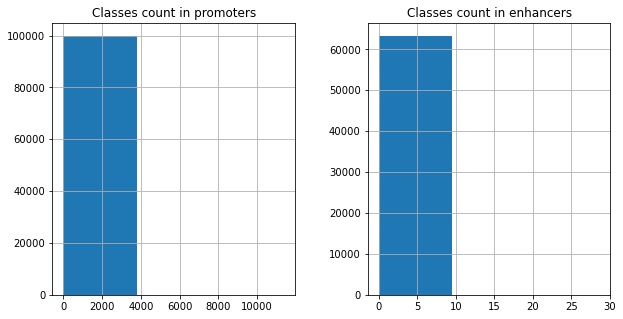

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    y.hist(ax=axis, bins=3)
    axis.set_title(f"Classes count in {region}")
fig.show()

## Constant features

In [26]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [27]:
for region, x in epigenomes.items():
    result = drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


## Z-scoring
In realtà usiamo una versione migliore di z-scoring, robust scaler, che gestisce meglio gli outlier, sottraendo la mediana e dividendo per la sd tra il primo quartile e il terzo

In [28]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

# Dictionary comprehension
epigenomes = {
    region: robust_zscoring(x)
    for region, x in epigenomes.items()
}

 ## Correlation with output
 
 se trovo features completamente non correlate all'output posso eliminarle

In [29]:
from tqdm.auto import tqdm 

🟥 p_value è una sorta di intervallo di confidenza? come viene calcolato?

In [31]:
# salvo le features non correlate all'interno del dict uncorrelated
uncorrelated = {
    region: set()
    for region in epigenomes
}

#### Pearson

🟥 visto che assume che i dati siano normalizzati, devo sempre fare z-scoring?

In [32]:
from scipy.stats import pearsonr

for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            print(region, column, correlation, "- pvalue = ", p_value)
            uncorrelated[region].add(column)

Running Pearson test for promoters:   0%|                                                       | 0/48 [00:00<…

promoters ZC3H11A -0.00021743447940157038 - pvalue =  0.9452148568387145
promoters PRDM1 0.007639434842807909 - pvalue =  0.015762507470316652
promoters EHMT2 0.003373545879994956 - pvalue =  0.286349681146986
promoters FOSB 0.0072934610937671895 - pvalue =  0.021165229224938846
promoters SREBF2 0.006681096810455964 - pvalue =  0.03473038852113338
promoters FOXF2 0.0020626623301107975 - pvalue =  0.5144815434347364
promoters RFX5 0.007223260400821491 - pvalue =  0.022439959406427318
promoters CHD4 0.0008994964099302842 - pvalue =  0.7762012184128849


Running Pearson test for enhancers:   0%|                                                       | 0/48 [00:00<…

enhancers ZC3H11A 0.002585249345050187 - pvalue =  0.5154682635217344
enhancers CBX2 -0.005538043453544163 - pvalue =  0.1635709215614667
enhancers EHMT2 0.007965151464461025 - pvalue =  0.04509724003836424


#### Spearman

In [33]:
from scipy.stats import spearmanr

for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Spearman test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            print(region, column, correlation)
            uncorrelated[region].add(column)

Running Spearman test for promoters:   0%|                                                      | 0/48 [00:00<…

Running Spearman test for enhancers:   0%|                                                      | 0/48 [00:00<…

enhancers CBX2 -0.0011977744523758835
enhancers KDM5A -0.003756719176732011


#### MIC (Maximal information coefficient) correlation

🟥🟥🟥 non riesco ad installare minepy 

In [1]:
!pip install minepy

  Using cached minepy-1.2.6.tar.gz (496 kB)
  Running setup.py clean for minepy
Failed to build minepy
    Running setup.py install for minepy: started
    Running setup.py install for minepy: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'D:\Programmi\Anaconda\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\ndemo\\AppData\\Local\\Temp\\pip-install-av6jo9bs\\minepy_a5acd9badfa94c39a049a907c7468bd6\\setup.py'"'"'; __file__='"'"'C:\\Users\\ndemo\\AppData\\Local\\Temp\\pip-install-av6jo9bs\\minepy_a5acd9badfa94c39a049a907c7468bd6\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\ndemo\AppData\Local\Temp\pip-wheel-mgfl2mh3'
       cwd: C:\Users\ndemo\AppData\Local\Temp\pip-install-av6jo9bs\minepy_a5acd9badfa94c39a049a907c7468bd6\
  Complete output (10 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating 

In [112]:
from minepy import MINE

for region, x in epigenomes.items():
    for column in tqdm(uncorrelated[region], desc=f"Running MINE test for {region}", dynamic_ncols=True, leave=False):
        mine = MINE()
        mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(region, column, score)
        else:
            uncorrelated[region].remove(column)

ModuleNotFoundError: No module named 'minepy'

#### Elimino features non correlate all'output

In [34]:
for region, x in epigenomes.items():
    epigenomes[region] =x.drop(columns=[
        col
        for col in uncorrelated[region]
        if col in x.columns
    ])

## Correlation between features

In [35]:
p_value_threshold = 0.01
correlation_threshold = 0.95

In [36]:
from scipy.stats import entropy

extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

for region, x in epigenomes.items():
    for i, column in tqdm(
        enumerate(x.columns),
        total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        for feature in x.columns[i+1:]:
            correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
            correlation = np.abs(correlation)
            scores[region].append((correlation, column, feature))
            if p_value < p_value_threshold and correlation > correlation_threshold:
                print(region, column, feature, correlation)
                if entropy(x[column]) > entropy(x[feature]):
                    extremely_correlated[region].add(feature)
                else:
                    extremely_correlated[region].add(column)

Running Pearson test for promoters:   0%|                                                       | 0/40 [00:00<…

Running Pearson test for enhancers:   0%|                                                       | 0/44 [00:00<…

In [37]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

In [46]:
(labels[region]['A549'] != 0).sum()/(labels[region]['A549'] == 0).sum()

0.060369960792198654

🟥🟥🟥

Most correlated features from promoters epigenomes


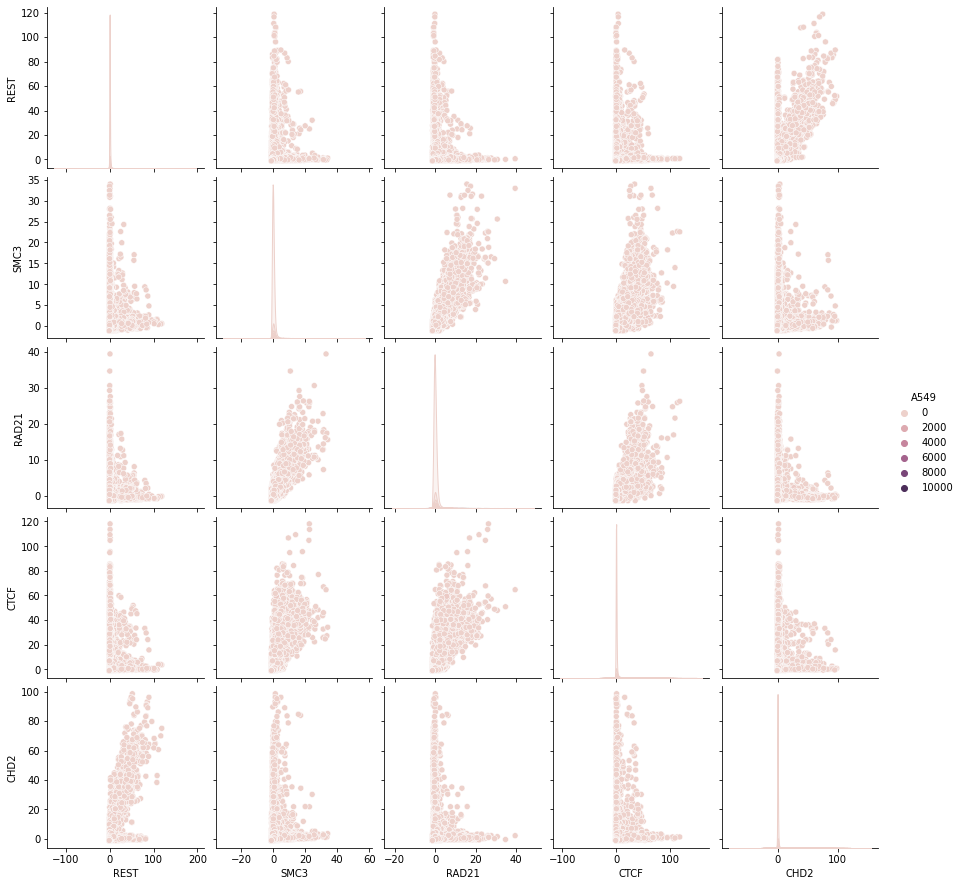

Most correlated features from enhancers epigenomes


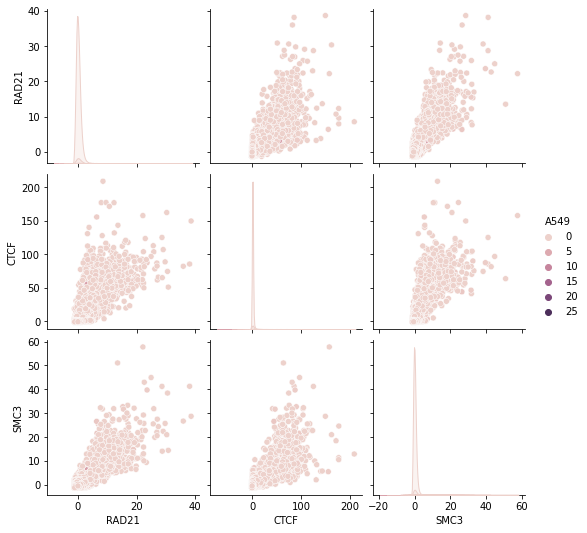

In [47]:
sns.set_palette("Reds")
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()